Current Solar Power Generation and Demand Analysis
--------------------------------------------------
Loaded data with 323428 solar installations

Current Solar Generation Potential:
Total Installed Capacity: 19030.06 MW
  - Rooftop Solar: 17678.09 MW (92.9%)
  - Ground-mounted Solar: 1351.97 MW (7.1%)
Daily Energy Production Potential: 53284.18 MWh
Monthly Energy Production Potential: 1598525.32 MWh
Annual Energy Production Potential: 19448724.75 MWh

Analysis complete. Generated visualizations for current solar generation and demand patterns.
Output files:
- current_hourly_solar_generation.png - Estimated hourly solar generation profile
- monthly_solar_generation.png - Monthly solar generation profile accounting for seasonal variations
- demand_vs_solar.png - Comparison of typical demand and solar generation throughout the day
- solar_contribution.png - Percentage of demand met by solar generation by hour


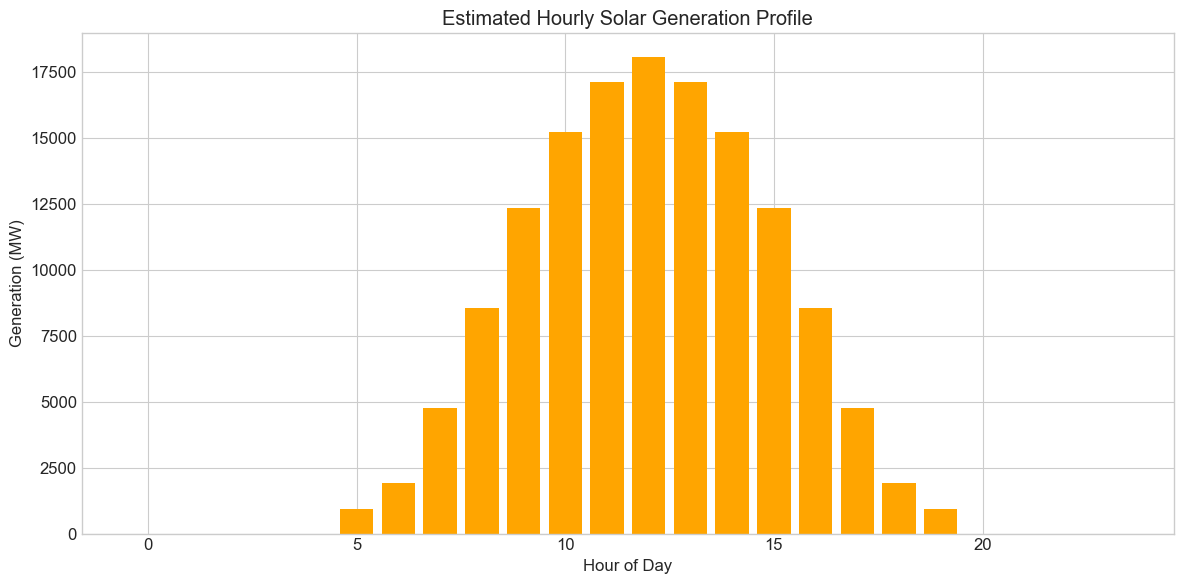

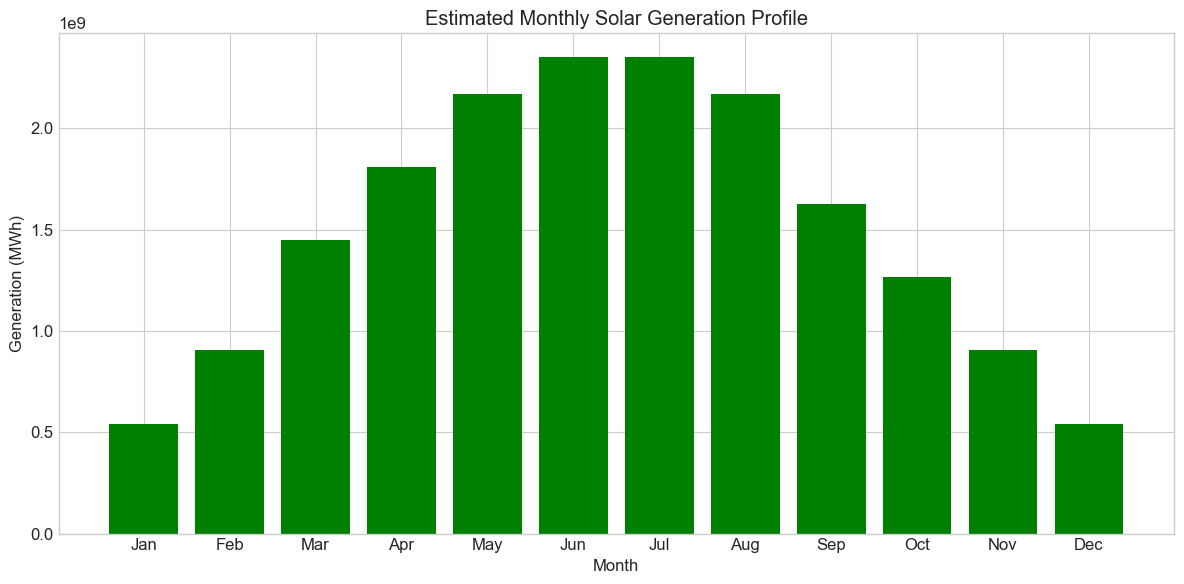

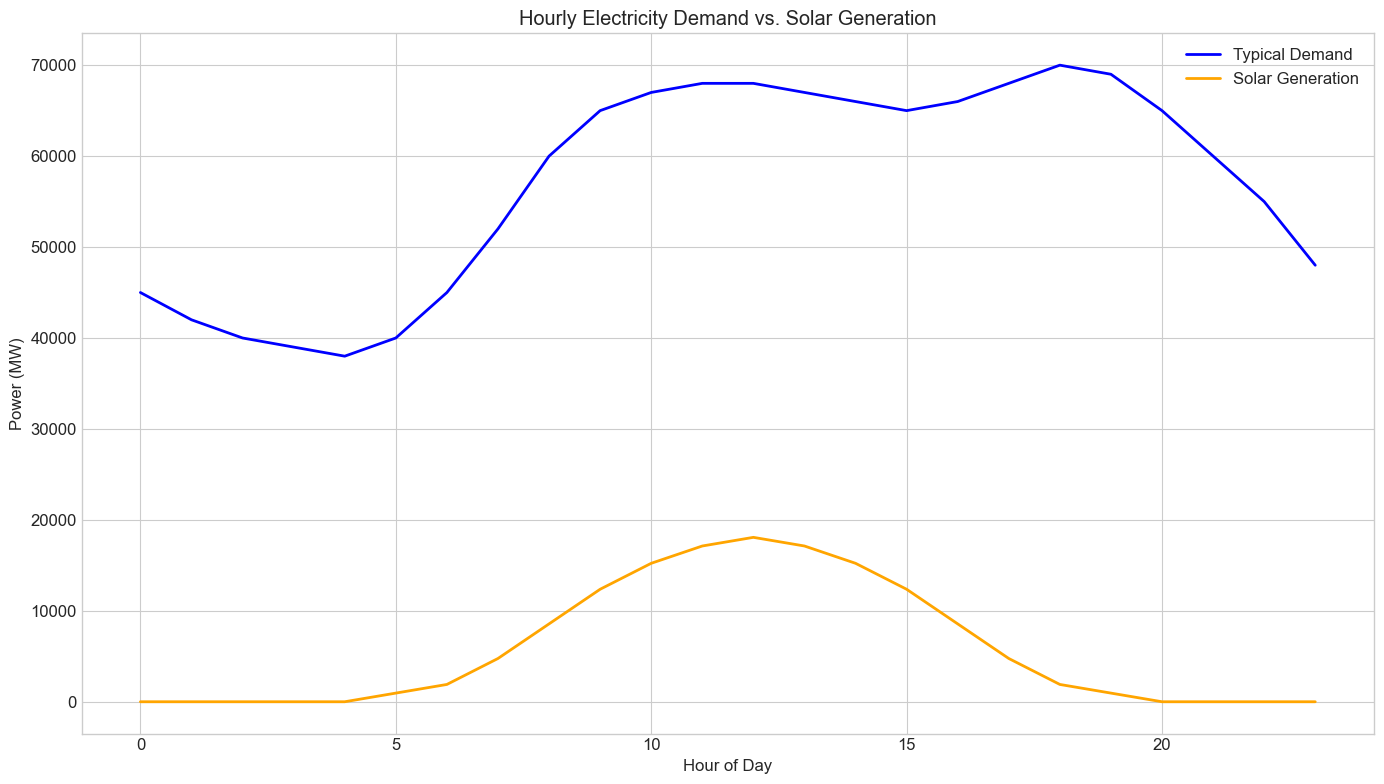

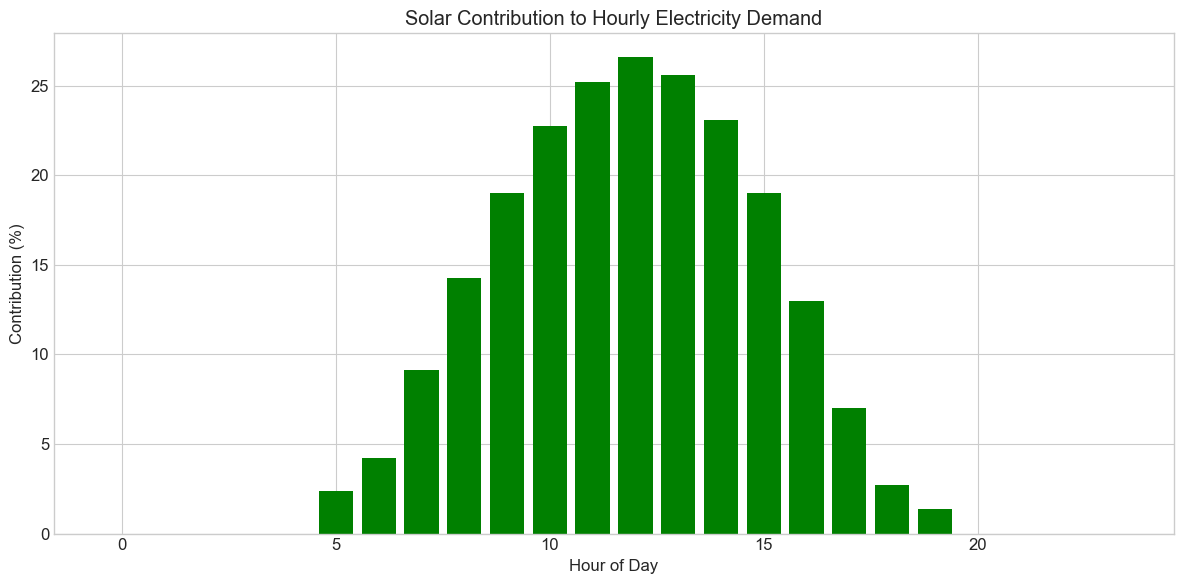

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import os

def calculate_current_generation_potential(solar_df):
    """
    Calculate the current generation potential based on installed capacity
    This estimates what the current solar fleet can produce
    """
    # Constants for solar energy calculations
    PEAK_SUN_HOURS = 3.5  # Average peak sun hours per day in Germany
    PERFORMANCE_RATIO = 0.8  # Typical performance ratio accounting for system losses
    
    # Calculate total installed capacity in MW
    total_rooftop_capacity = solar_df[solar_df['Energietraeger'] == 9]['Installierte_Leistung'].sum() / 1000  # Convert kW to MW
    total_ground_capacity = solar_df[solar_df['Energietraeger'] == 8]['Installierte_Leistung'].sum() / 1000  # Convert kW to MW
    total_capacity = total_rooftop_capacity + total_ground_capacity
    
    # Calculate daily energy production potential (MWh)
    daily_energy_potential = total_capacity * PEAK_SUN_HOURS * PERFORMANCE_RATIO
    
    # Calculate monthly and annual potential
    monthly_energy_potential = daily_energy_potential * 30  # Approximate
    annual_energy_potential = daily_energy_potential * 365
    
    return {
        'total_capacity_mw': total_capacity,
        'rooftop_capacity_mw': total_rooftop_capacity,
        'ground_capacity_mw': total_ground_capacity,
        'daily_energy_mwh': daily_energy_potential,
        'monthly_energy_mwh': monthly_energy_potential,
        'annual_energy_mwh': annual_energy_potential
    }

def estimate_current_output_by_hour(solar_df, date=None):
    """
    Estimate hourly output profile for the current installed capacity
    """
    if date is None:
        date = datetime.now().strftime('%Y-%m-%d')
    
    # Total capacity in MW
    total_capacity = solar_df['Installierte_Leistung'].sum() / 1000  # Convert kW to MW
    
    # Create hourly output profile based on typical sunny day in Germany
    # These are normalized values (percentage of peak capacity)
    hourly_profile = {
        0: 0.00, 1: 0.00, 2: 0.00, 3: 0.00, 4: 0.00, 5: 0.05,
        6: 0.10, 7: 0.25, 8: 0.45, 9: 0.65, 10: 0.80, 11: 0.90,
        12: 0.95, 13: 0.90, 14: 0.80, 15: 0.65, 16: 0.45, 17: 0.25,
        18: 0.10, 19: 0.05, 20: 0.00, 21: 0.00, 22: 0.00, 23: 0.00
    }
    
    # Apply profile to total capacity
    hourly_output = {}
    for hour, factor in hourly_profile.items():
        hourly_output[hour] = total_capacity * factor
    
    return hourly_output

def estimate_seasonal_profile(solar_df):
    """
    Estimate monthly generation profile based on seasonal variations
    """
    # Total capacity in MW
    total_capacity = solar_df['Installierte_Leistung'].sum() / 1000
    
    # Monthly factors for Germany (approximate percentage of annual production)
    monthly_factors = {
        'Jan': 0.03, 'Feb': 0.05, 'Mar': 0.08, 'Apr': 0.10,
        'May': 0.12, 'Jun': 0.13, 'Jul': 0.13, 'Aug': 0.12,
        'Sep': 0.09, 'Oct': 0.07, 'Nov': 0.05, 'Dec': 0.03
    }
    
    # Calculate monthly production in MWh
    ANNUAL_YIELD = 950  # Approximate annual yield in kWh/kWp for Germany
    annual_production = total_capacity * ANNUAL_YIELD * 1000  # In MWh
    
    monthly_production = {}
    for month, factor in monthly_factors.items():
        monthly_production[month] = annual_production * factor
    
    return monthly_production

def analyze_demand_supply_balance(solar_df):
    """
    Analyze the balance between solar generation and typical demand
    """
    # Total solar capacity in MW
    total_capacity = solar_df['Installierte_Leistung'].sum() / 1000
    
    # Typical hourly demand profile for Germany (in MW, approximate)
    hourly_demand = {
        0: 45000, 1: 42000, 2: 40000, 3: 39000, 4: 38000, 5: 40000,
        6: 45000, 7: 52000, 8: 60000, 9: 65000, 10: 67000, 11: 68000,
        12: 68000, 13: 67000, 14: 66000, 15: 65000, 16: 66000, 17: 68000,
        18: 70000, 19: 69000, 20: 65000, 21: 60000, 22: 55000, 23: 48000
    }
    
    # Estimate solar generation
    hourly_solar = estimate_current_output_by_hour(solar_df)
    
    # Calculate solar contribution to demand
    solar_contribution = {}
    for hour, demand in hourly_demand.items():
        solar_generation = hourly_solar[hour]
        solar_contribution[hour] = (solar_generation / demand) * 100 if demand > 0 else 0
    
    return {
        'hourly_demand': hourly_demand,
        'hourly_solar': hourly_solar,
        'solar_contribution': solar_contribution
    }

def main():
    print("Current Solar Power Generation and Demand Analysis")
    print("-" * 50)
    
    # Load the processed solar installation data
    try:
        solar_df = pd.read_csv('50hertz_solar_installations.csv')
        print(f"Loaded data with {len(solar_df)} solar installations")
    except FileNotFoundError:
        print("Solar installation data file not found. Please run the previous script first.")
        return
    
    # Ensure capacity is in numeric format
    if solar_df['Installierte_Leistung'].dtype != 'float64':
        solar_df['Installierte_Leistung'] = pd.to_numeric(solar_df['Installierte_Leistung'], errors='coerce')
    
    # 1. Calculate current generation potential
    generation_potential = calculate_current_generation_potential(solar_df)
    
    print("\nCurrent Solar Generation Potential:")
    print(f"Total Installed Capacity: {generation_potential['total_capacity_mw']:.2f} MW")
    print(f"  - Rooftop Solar: {generation_potential['rooftop_capacity_mw']:.2f} MW ({generation_potential['rooftop_capacity_mw']/generation_potential['total_capacity_mw']*100:.1f}%)")
    print(f"  - Ground-mounted Solar: {generation_potential['ground_capacity_mw']:.2f} MW ({generation_potential['ground_capacity_mw']/generation_potential['total_capacity_mw']*100:.1f}%)")
    print(f"Daily Energy Production Potential: {generation_potential['daily_energy_mwh']:.2f} MWh")
    print(f"Monthly Energy Production Potential: {generation_potential['monthly_energy_mwh']:.2f} MWh")
    print(f"Annual Energy Production Potential: {generation_potential['annual_energy_mwh']:.2f} MWh")
    
    # 2. Estimate current hourly output profile
    hourly_output = estimate_current_output_by_hour(solar_df)
    
    # Plot hourly output
    plt.figure(figsize=(12, 6))
    plt.bar(hourly_output.keys(), hourly_output.values(), color='orange')
    plt.title('Estimated Hourly Solar Generation Profile')
    plt.xlabel('Hour of Day')
    plt.ylabel('Generation (MW)')
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.savefig('current_hourly_solar_generation.png')
    
    # 3. Estimate seasonal generation profile
    monthly_production = estimate_seasonal_profile(solar_df)
    
    # Plot monthly production
    plt.figure(figsize=(12, 6))
    plt.bar(monthly_production.keys(), monthly_production.values(), color='green')
    plt.title('Estimated Monthly Solar Generation Profile')
    plt.xlabel('Month')
    plt.ylabel('Generation (MWh)')
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.savefig('monthly_solar_generation.png')
    
    # 4. Analyze demand-supply balance
    balance = analyze_demand_supply_balance(solar_df)
    
    # Plot demand vs. solar generation
    plt.figure(figsize=(14, 8))
    plt.plot(balance['hourly_demand'].keys(), balance['hourly_demand'].values(), 'b-', linewidth=2, label='Typical Demand')
    plt.plot(balance['hourly_solar'].keys(), balance['hourly_solar'].values(), 'orange', linewidth=2, label='Solar Generation')
    plt.title('Hourly Electricity Demand vs. Solar Generation')
    plt.xlabel('Hour of Day')
    plt.ylabel('Power (MW)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('demand_vs_solar.png')
    
    # Plot solar contribution to demand
    plt.figure(figsize=(12, 6))
    plt.bar(balance['solar_contribution'].keys(), balance['solar_contribution'].values(), color='green')
    plt.title('Solar Contribution to Hourly Electricity Demand')
    plt.xlabel('Hour of Day')
    plt.ylabel('Contribution (%)')
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.savefig('solar_contribution.png')
    
    print("\nAnalysis complete. Generated visualizations for current solar generation and demand patterns.")
    print("Output files:")
    print("- current_hourly_solar_generation.png - Estimated hourly solar generation profile")
    print("- monthly_solar_generation.png - Monthly solar generation profile accounting for seasonal variations")
    print("- demand_vs_solar.png - Comparison of typical demand and solar generation throughout the day")
    print("- solar_contribution.png - Percentage of demand met by solar generation by hour")

if __name__ == "__main__":
    main()